In [201]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from torchvision import models
!pip install torchsummary
from torchsummary import summary

### Read the Monte Carlo Based Simulation Data

In [202]:
data = pd.read_csv('MC_Modeled_spectra.csv')

### Split the data in to Input X (Wavelengths ) and Intended measurements (Melanin and Oxygen Saturation) 

In [203]:
X, Y = pd.DataFrame(), pd.DataFrame()
for i, column in enumerate(data.columns):
    #read only wavelengths from 510 nm to 720 nm
    if column.isnumeric() and i >= 46 and i<= 67  :
        X[column] = data[column]
    elif column == 'Mel' or column == 'BlSDBN':
        Y[column] = data[column]
d = pd.DataFrame(np.zeros((X.shape[0],3)))

X = pd.concat([d,X], axis = 1)


In [204]:
X = X.astype(np.float32)
Y = Y.astype(np.float32)
X = torch.from_numpy(X.values)
X = X.reshape(-1,1,5,5)
Y = torch.from_numpy(Y.values)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

torch.Size([174960, 1, 5, 5]) torch.Size([174960, 2]) torch.Size([43740, 1, 5, 5]) torch.Size([43740, 2])


In [205]:
class MCSpectraDataset(torch.utils.data.Dataset):
  '''
  Prepare the MC Spectra dataset for regression
  '''

  def __init__(self, X, y, scale_data=True):
    self.X = X
    self.y = y
  

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.y[i]

In [206]:
class CNN(nn.Module):
    '''
    CNN for regression on Monte Carlo simulated data
    '''
    
    def __init__(self, kernelSize = 3):
        super().__init__()
        flattened_out = 1600
        if kernelSize == 4:
             flattened_out = 256
        self.layers = nn.Sequential(
            #Input = 5 x 5 X 1, Output = 20 x 5 x 5
            torch.nn.Conv2d(in_channels = 1, out_channels = 20, kernel_size =kernelSize, padding = 1), 
            torch.nn.ReLU(),
  
            #Input = 32 x 16 x 16, Output = 64 x 16 x 16
            torch.nn.Conv2d(in_channels = 20, out_channels = 64, kernel_size = kernelSize, padding = 1),
            torch.nn.ReLU(),
              
            #Input = 64 x 8 x 8, Output = 64 x 8 x 8
            torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = kernelSize, padding = 1),
            torch.nn.ReLU(),
  
            torch.nn.Flatten(),
            torch.nn.Linear(flattened_out , 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 2)
        )
    
    def forward(self,x):
        return self.layers(x)

In [208]:
dataset = MCSpectraDataset(X_train, Y_train, scale_data=True)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)

In [ ]:
## summary of nn model
cnn = CNN(3)
summary(cnn, (1, 5, 5))

In [209]:
loss_f = nn.MSELoss()
def train_model(epochs, learning_rate, kernelSize):
    loss_line = []
    cnn = CNN(kernelSize)
    optimizer = torch.optim.Adam(cnn.parameters(), lr = learning_rate)
    # Run the training loop
    for epoch in range(0, epochs): # 5 epochs at maximum

        # Print epoch
        print(f'Starting epoch {epoch+1}')

        # Set current loss value

        # Iterate over the DataLoader for training data
        for i, data in enumerate(trainloader, 0):

          # Get and prepare inputs
            inputs, targets = data
            inputs, targets = inputs.float(), targets.float()
            targets = targets.reshape((targets.shape[0], 2))

          # Zero the gradients
            optimizer.zero_grad()

          # Perform forward pass
            outputs = cnn(inputs)

          # Compute loss
            loss = loss_f(outputs, targets)

          # Perform backward pass
            loss.backward()

          # Perform optimization
            optimizer.step()

          # Print statistics

            if i % 3000 == 0:
                print('Loss after mini-batch %5d: %.8f' % (i + 1, loss.item() ))
                loss_line.append(loss.item())

      # Process is complete.
    print('Training process has finished.')
    return cnn, loss_line

### Training 3 models with 3 different kernel sizes.

In [210]:


lr = 1e-4
epochs = 2

##kernel size 3
kernelSize0 = 3
mlpk1, losslinek1 = train_model(epochs, lr, kernelSize0)
Y_pred_k1 = mlpk1(X_test)

##kernel size 3
kernelSize1 = 4
mlpk2, losslinek2 = train_model(epochs, lr, kernelSize1)
Y_pred_k2 = mlpk2(X_test)


Starting epoch 1
Loss after mini-batch     1: 0.17162034
Loss after mini-batch  3001: 0.00676366
Loss after mini-batch  6001: 0.00414310
Loss after mini-batch  9001: 0.00374431
Loss after mini-batch 12001: 0.00269853
Loss after mini-batch 15001: 0.00274983
Starting epoch 2
Loss after mini-batch     1: 0.00451315
Loss after mini-batch  3001: 0.00407966
Loss after mini-batch  6001: 0.00379136
Loss after mini-batch  9001: 0.00398976
Loss after mini-batch 12001: 0.00305062
Loss after mini-batch 15001: 0.00139850
Training process has finished.
Starting epoch 1
Loss after mini-batch     1: 0.21819396
Loss after mini-batch  3001: 0.00344911
Loss after mini-batch  6001: 0.00390914
Loss after mini-batch  9001: 0.00276845
Loss after mini-batch 12001: 0.00315094
Loss after mini-batch 15001: 0.00152873
Starting epoch 2
Loss after mini-batch     1: 0.00352571
Loss after mini-batch  3001: 0.00395794
Loss after mini-batch  6001: 0.00242626
Loss after mini-batch  9001: 0.00260154
Loss after mini-batch

In [211]:
MSEk1 = float("{:.6f}".format(loss_f(Y_pred_k1,Y_test)))
MSEk2 = float("{:.6f}".format(loss_f(Y_pred_k2,Y_test)))


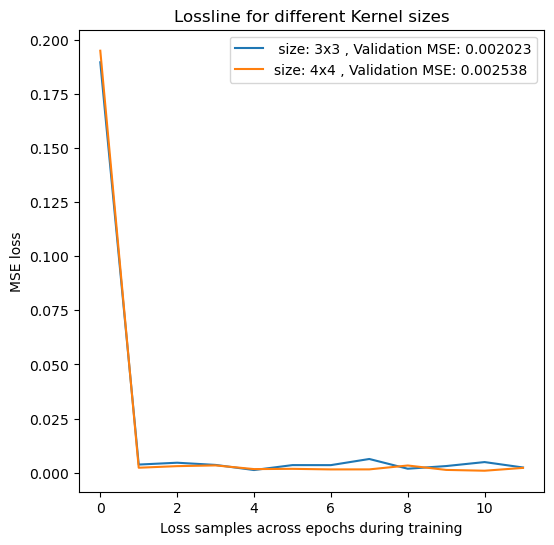

In [212]:
fig = plt.figure(figsize=(6,6))
plt.title('Lossline for different Kernel sizes')
plt.xlabel('Loss samples across epochs during training')
plt.ylabel('MSE loss')
plt.plot(lossline1)
plt.plot(lossline2)
plt.legend([f" size: 3x3 , Validation MSE: {MSEk1}", f"size: 4x4 , Validation MSE: {MSEk2}"], loc ="upper right")

### Training 3 models with 3 different learning rates.

In [214]:


lr1 = 1e-4
epochs = 2
kernelSize = 3
mlp1, lossline1 = train_model(epochs, lr1,kernelSize )
Y_pred_1 = mlp1(X_test)

lr2 = 1e-3
mlp2, lossline2 = train_model(epochs, lr2, kernelSize)
Y_pred_2 = mlp2(X_test)

lr3 = 1e-2
mlp3, lossline3 = train_model(epochs, lr3, kernelSize)
Y_pred_3 = mlp3(X_test)


Starting epoch 1
Loss after mini-batch     1: 0.20357522
Loss after mini-batch  3001: 0.00373227
Loss after mini-batch  6001: 0.00429076
Loss after mini-batch  9001: 0.00269224
Loss after mini-batch 12001: 0.00508605
Loss after mini-batch 15001: 0.00190354
Starting epoch 2
Loss after mini-batch     1: 0.00518527
Loss after mini-batch  3001: 0.00306071
Loss after mini-batch  6001: 0.00340916
Loss after mini-batch  9001: 0.00208067
Loss after mini-batch 12001: 0.00153231
Loss after mini-batch 15001: 0.00209356
Training process has finished.
Starting epoch 1
Loss after mini-batch     1: 0.20586877
Loss after mini-batch  3001: 0.00321104
Loss after mini-batch  6001: 0.00580491
Loss after mini-batch  9001: 0.00248519
Loss after mini-batch 12001: 0.00264155
Loss after mini-batch 15001: 0.00417038
Starting epoch 2
Loss after mini-batch     1: 0.00318388
Loss after mini-batch  3001: 0.00227556
Loss after mini-batch  6001: 0.00131993
Loss after mini-batch  9001: 0.00161765
Loss after mini-batch

In [215]:

MSE1 = float("{:.6f}".format(loss_f(Y_pred_1,Y_test)))
MSE2 = float("{:.6f}".format(loss_f(Y_pred_2,Y_test)))
MSE3 = float("{:.6f}".format(loss_f(Y_pred_3,Y_test)))


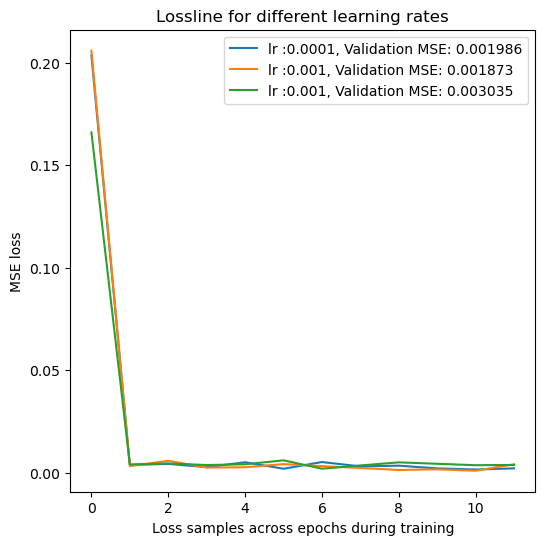

In [216]:
fig = plt.figure(figsize=(6,6))
plt.title('Lossline for different learning rates')
plt.xlabel('Loss samples across epochs during training')
plt.ylabel('MSE loss')
plt.plot(lossline1)
plt.plot(lossline2)
plt.plot(lossline3)
plt.legend([f"lr :{1e-4}, Validation MSE: {MSE1}", f"lr :{1e-3}, Validation MSE: {MSE2}", f"lr :{1e-3}, Validation MSE: {MSE3}"], loc ="upper right")

### Training models for different number of epochs

In [217]:
lr = 1e-4
epochs_1 = 2
mlp4, lossline4 = train_model(epochs_1, lr, kernelSize)
Y_pred_4 = mlp1(X_test)

Starting epoch 1
Loss after mini-batch     1: 0.20962560
Loss after mini-batch  3001: 0.00530823
Loss after mini-batch  6001: 0.00495859
Loss after mini-batch  9001: 0.00347325
Loss after mini-batch 12001: 0.00193094
Loss after mini-batch 15001: 0.00442822
Starting epoch 2
Loss after mini-batch     1: 0.00414403
Loss after mini-batch  3001: 0.00300016
Loss after mini-batch  6001: 0.00250178
Loss after mini-batch  9001: 0.00476699
Loss after mini-batch 12001: 0.00392995
Loss after mini-batch 15001: 0.00169687
Training process has finished.


In [218]:

epochs_2 = 4
mlp5, lossline5 = train_model(epochs_2, lr, kernelSize)
Y_pred_5 = mlp2(X_test)


epochs_3 = 6
mlp6, lossline6 = train_model(epochs_3, lr, kernelSize)
Y_pred_6 = mlp3(X_test)


Starting epoch 1
Loss after mini-batch     1: 0.20021050
Loss after mini-batch  3001: 0.00337801
Loss after mini-batch  6001: 0.00507627
Loss after mini-batch  9001: 0.00411303
Loss after mini-batch 12001: 0.00386872
Loss after mini-batch 15001: 0.00242817
Starting epoch 2
Loss after mini-batch     1: 0.00261005
Loss after mini-batch  3001: 0.00461318
Loss after mini-batch  6001: 0.00248776
Loss after mini-batch  9001: 0.00403589
Loss after mini-batch 12001: 0.00255736
Loss after mini-batch 15001: 0.00408273
Starting epoch 3
Loss after mini-batch     1: 0.00153044
Loss after mini-batch  3001: 0.00185848
Loss after mini-batch  6001: 0.00130512
Loss after mini-batch  9001: 0.00092398
Loss after mini-batch 12001: 0.00083860
Loss after mini-batch 15001: 0.00137980
Starting epoch 4
Loss after mini-batch     1: 0.00391425
Loss after mini-batch  3001: 0.00111253
Loss after mini-batch  6001: 0.00350252
Loss after mini-batch  9001: 0.00084437
Loss after mini-batch 12001: 0.00333672
Loss after m

In [219]:

MSE4 = float("{:.6f}".format(loss_f(Y_pred_4,Y_test)))
MSE5 = float("{:.6f}".format(loss_f(Y_pred_5,Y_test)))
MSE6 = float("{:.6f}".format(loss_f(Y_pred_6,Y_test)))


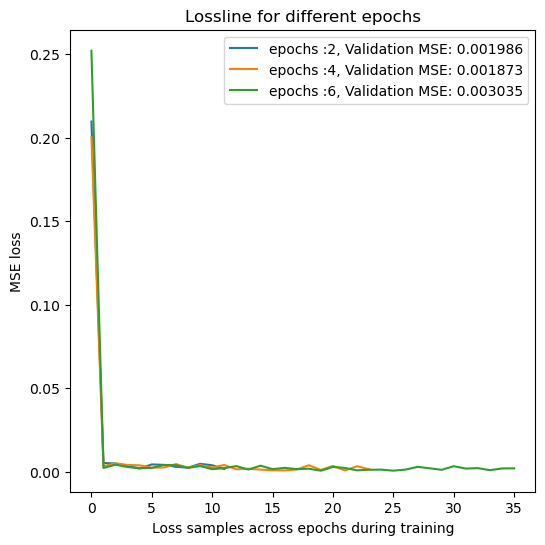

In [220]:
fig = plt.figure(figsize=(6,6))
plt.title('Lossline for different epochs')
plt.xlabel('Loss samples across epochs during training')
plt.ylabel('MSE loss')
plt.plot(lossline4)
plt.plot(lossline5)
plt.plot(lossline6)
plt.legend([f"epochs :{2}, Validation MSE: {MSE4}", f"epochs :{4}, Validation MSE: {MSE5}", f"epochs :{6}, Validation MSE: {MSE6}"], loc ="upper right")

### Prediction of Melanin using the trained MLP model

In [221]:
Results = np.load("R_(1measurement)_normalized_NoGap[202,202,79].matData_small.csv.npy");
x_total  = 202;
y_total  = 202;

# Melanin in living epidermis

Mel_True = Results[:,:,4].reshape(x_total * y_total, -1 );

# Blood Saturation in DBN

Blood_BISDBN_True =  Results[:,:,10].reshape(x_total * y_total, -1 );
print(Mel_True.shape, Blood_BISDBN_True.shape)


(40804, 1) (40804, 1)


In [222]:
folder = "Data_Mike";
filename = "R_(1measurement)_normalized_NoGap[202,202,79].mat";
folder = folder + "/";
data_file_to_load = folder + filename;
HSI_Data= loadmat(data_file_to_load);
Hyperspectra_data = HSI_Data['R1']
Hyperspectra_data[np.isinf(Hyperspectra_data)] = 0
Hyperspectra_data_resized = Hyperspectra_data[:,:, 0:43:2]; # Get from 510 to 720 nm with 10nm step size
(x_total, y_total, wavelenght) = Hyperspectra_data_resized.shape;
print("Hyperspectral data: x_total", x_total, "y_total", y_total, "wavelenth",wavelenght);
Hyperspectra_data_reshaped = Hyperspectra_data_resized.reshape(x_total*y_total,-1).astype(np.float32)

print("Hyperspectral reshaped size",Hyperspectra_data_reshaped.shape)

Hyperspectral data: x_total 202 y_total 202 wavelenth 22
Hyperspectral reshaped size (40804, 22)


In [223]:
padding = np.zeros((Hyperspectra_data_reshaped.shape[0],3))
HSI_CNN_input = np.column_stack((padding,Hyperspectra_data_reshaped)).reshape(-1,1,5,5)
HSI_CNN_input.shape

(40804, 1, 5, 5)

In [224]:

HSI = torch.from_numpy(HSI_CNN_input.astype(np.float32))
Y_pred_8 = mlp4(HSI).detach().numpy()
#MSE7 = float("{:.6f}".format(loss_f(Y_pred_8,Y_test)))


In [225]:

MSE_Melanin = mean_squared_error(Mel_True[:,0], Y_pred_8[:,0])
MSE_BloodOx = mean_squared_error(Blood_BISDBN_True[:,0], Y_pred_8[:,1])
print(f'MSE Melanin : {MSE_Melanin}, MSE BloodOxSat: {MSE_BloodOx}')


R2_Mel = r2_score(Mel_True[:,0], Y_pred_8[:,0])
R2_Oxy = r2_score(Blood_BISDBN_True[:,0], Y_pred_8[:,1])
print(f'R2 Melanin: {R2_Mel}, R2 BloodOxSat: {R2_Oxy}')

MSE Melanin : 0.16090904762841451, MSE BloodOxSat: 0.03398066132976184
R2 Melanin: -26.312534242809946, R2 BloodOxSat: -5.478813601220538


In [226]:
Y_pred_8_reshaped = Y_pred_8.reshape(x_total, y_total,-1)

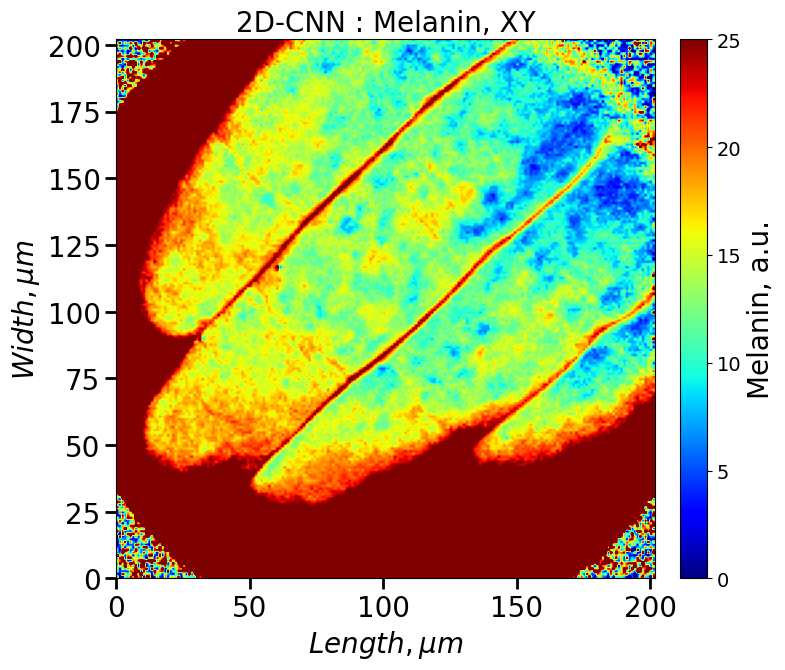

In [229]:
fig_mel = plt.figure(figsize=(8,7));
ax_mel = fig_mel.add_subplot(111);
plot_mel = ax_mel.imshow(Y_pred_8_reshaped[:,:,0] * 100, extent=(0,x_total,0,y_total), cmap='jet');
ax_mel.set_ylabel(r'$Width, \mu m$', fontsize=20);
ax_mel.set_xlabel(r'$Length, \mu m$', fontsize=20);
ax_mel.yaxis.set_ticks_position('left');
ax_mel.xaxis.set_ticks_position('bottom');
ax_mel.tick_params(axis='both',reset=False,which='both',length=8,width=2,labelsize=20);
ax_mel.set_title('2D-CNN : Melanin, XY', fontsize=20);
plot_mel.set_clim(vmin=0, vmax=25.0);
cbar_mel = fig_mel.colorbar(plot_mel, fraction=0.046, pad=0.04);
cbar_mel.set_label('Melanin, a.u.',size=20);
cbar_mel.ax.tick_params(labelsize=14) ;
plt.show();

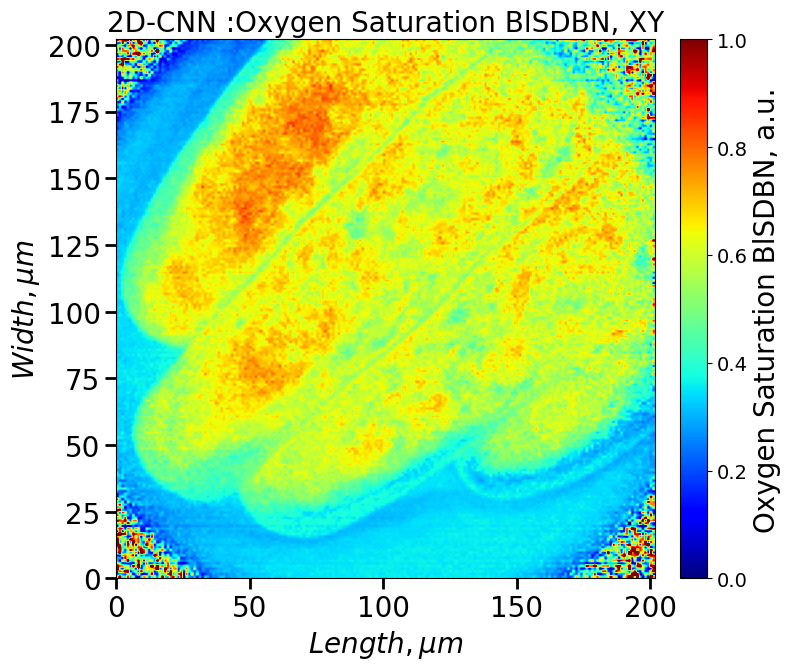

In [230]:
fig_blood_BlSDBN = plt.figure(figsize=(8,7));
ax_blood_BlSDBN = fig_blood_BlSDBN.add_subplot(111);
plot_blood_BlSDBN = ax_blood_BlSDBN.imshow(Y_pred_8_reshaped[:,:,1], extent=(0,x_total,0,y_total), cmap='jet');
ax_blood_BlSDBN.set_ylabel(r'$Width, \mu m$', fontsize=20);
ax_blood_BlSDBN.set_xlabel(r'$Length, \mu m$', fontsize=20);
ax_blood_BlSDBN.yaxis.set_ticks_position('left');
ax_blood_BlSDBN.xaxis.set_ticks_position('bottom');
ax_blood_BlSDBN.tick_params(axis='both',reset=False,which='both',length=8,width=2,labelsize=20);
ax_blood_BlSDBN.set_title('2D-CNN :Oxygen Saturation BlSDBN, XY', fontsize=20);
plot_blood_BlSDBN.set_clim(vmin=0, vmax=1.0);
cbar_blood_BlSDBN = fig_blood_BlSDBN.colorbar(plot_blood_BlSDBN, fraction=0.046, pad=0.04);
cbar_blood_BlSDBN.set_label('Oxygen Saturation BlSDBN, a.u.',size=20);
cbar_blood_BlSDBN.ax.tick_params(labelsize=14) ;
plt.show();